In [1]:
from sklearn import preprocessing
from sklearn import model_selection

import evopipe
import steps
import warnings

from sklearn.model_selection import train_test_split
from sklearn import datasets

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
wine = datasets.load_wine()
train_X, test_X, train_Y, test_Y = train_test_split(wine.data, wine.target, test_size = 0.25, random_state = 0)

params = steps.get_params(len(train_X[0]))

In [3]:
print("Format:")
print("------------")
print("Classifier")
print("score")
print("cross-validation score")
print("GridSearch score")
print("------------")
print()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for name, cls in steps.clfs.items():
        classif = cls()
        print(classif.__class__.__name__)
        classif.fit(train_X, train_Y)
        print(classif.score(test_X, test_Y))
        print(model_selection.cross_val_score(classif, test_X, test_Y).mean())
        
        pipe_params = params[name]
        gs = model_selection.GridSearchCV(classif, params,n_jobs=-1, pre_dispatch='2*n_jobs', verbose=5)
        gs.fit(train_X, train_Y)
        
        print(gs.best_params_)
        print(gs.score(test_X, test_Y))
        print()

Format:
------------
Classifier
score
cross-validation score
GridSearch score
------------

SVC
0.5111111111111111
0.4680555555555556


AttributeError: module 'steps' has no attribute 'params'

In [3]:
clf = evopipe.EvoPipeClassifier(steps.preproc, steps.clfs, params)
clf.fit(train_X, train_Y, test_X, test_Y)

score = clf.score(test_X, test_Y)
print("\nBest pipeline test score: {}\n".format(score))

best_pipes = clf.best_pipelines()

for pipe in best_pipes:
    pipe.fit(train_X, train_Y)
    score = pipe.score(test_X, test_Y)
    
    pipe_named_steps = []
    for key, val in pipe.steps:
        pipe_named_steps.append(key)       
    print("Score: {}, Pipe: {}".format(score, pipe_named_steps))


Gen 6:

Hall of fame:
[('LDA', {'solver': 'lsqr', 'shrinkage': None})]
[('kBest', {'k': 13}), ('QDA', {'reg_param': 0.1, 'tol': 0.01})]
[('gaussianNB', {})]
[('QDA', {'reg_param': 0.1, 'tol': 0.01})]
[('LDA', {'solver': 'lsqr', 'shrinkage': 'auto'})]

Gen 11:

Hall of fame:
[('LDA', {'solver': 'lsqr', 'shrinkage': None})]
[('kBest', {'k': 13}), ('QDA', {'reg_param': 0.1, 'tol': 0.01})]
[('gaussianNB', {})]
[('QDA', {'reg_param': 0.1, 'tol': 0.01})]
[('LDA', {'solver': 'lsqr', 'shrinkage': 'auto'})]

Gen 16:

Hall of fame:
[('LDA', {'solver': 'lsqr', 'shrinkage': None})]
[('kBest', {'k': 13}), ('QDA', {'reg_param': 0.1, 'tol': 0.01})]
[('gaussianNB', {})]
[('QDA', {'reg_param': 0.1, 'tol': 0.01})]
[('LDA', {'solver': 'lsqr', 'shrinkage': 'auto'})]

Gen 21:

Hall of fame:
[('LDA', {'solver': 'lsqr', 'shrinkage': None})]
[('kBest', {'k': 13}), ('QDA', {'reg_param': 0.1, 'tol': 0.01})]
[('gaussianNB', {})]
[('QDA', {'reg_param': 0.1, 'tol': 0.01})]
[('LDA', {'solver': 'lsqr', 'shrinkage':

   	                    fitness                     	                   train_test                   
   	------------------------------------------------	------------------------------------------------
gen	gen	avg     	min     	max     	gen	avg     	min     	max     
1  	   	0.524817	0       	0.978571	   	0.588148	0       	1       
2  	   	0.774414	0.422527	0.978571	   	0.861481	0.466667	0.977778
3  	   	0.877912	0.669231	0.978571	   	0.915556	0.755556	0.977778
4  	   	0.939286	0.692308	0.978571	   	0.948889	0.733333	0.977778
5  	   	0.978168	0.977473	0.978571	   	0.971852	0.933333	0.977778
6  	   	0.978571	0.978571	0.978571	   	0.977778	0.977778	0.977778
7  	   	0.978571	0.978571	0.978571	   	0.977778	0.977778	0.977778
8  	   	0.978571	0.978571	0.978571	   	0.977778	0.977778	0.977778
9  	   	0.978571	0.978571	0.978571	   	0.977778	0.977778	0.977778
10 	   	0.978571	0.978571	0.978571	   	0.977778	0.977778	0.977778
11 	   	0.978571	0.978571	0.978571	   	0.977778	0.977778	0.977778
12 	

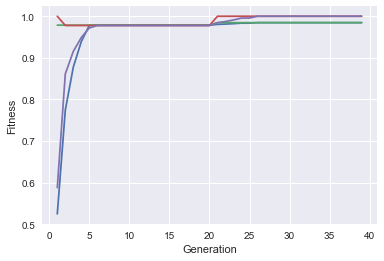

In [4]:
print(clf.logbook)

gen = clf.logbook.select("gen")
avgs, mins, maxs, vars = clf.logbook.chapters["fitness"].select("avg", "min", "max", "var")
avgs_tt, mins_tt, maxs_tt, vars_tt = clf.logbook.chapters["train_test"].select("avg", "min", "max", "var")

sns.set()

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(gen, avgs, label='Average')
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")

ax1.plot(gen, maxs, label='Maximum')

ax1.plot(gen, maxs_tt, label='Maximum test')
ax1.plot(gen, avgs_tt, label='Average test')

plt.show()